In [1]:
import os
from PIL import Image

!pip3 install -q torch torchvision
!pip3 install -q Pillow
!pip3 install -q imgaug==0.2.5

     |████████████████████████████████| 563kB 5.6MB/s 


In [2]:
!wget "https://storage.googleapis.com/dlcourse_ai/train.zip"
!unzip -q "train.zip"

train_folder = "train_kaggle/"


!wget "https://storage.googleapis.com/dlcourse_ai/test.zip"
!unzip -q "test.zip"

test_folder = "test_kaggle/"

--2021-03-18 16:08:53--  https://storage.googleapis.com/dlcourse_ai/train.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 562348083 (536M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>] 536.30M  95.4MB/s    in 5.6s    

2021-03-18 16:08:59 (95.2 MB/s) - ‘train.zip’ saved [562348083/562348083]

--2021-03-18 16:09:04--  https://storage.googleapis.com/dlcourse_ai/test.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 64.233.189.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 140788786 (134M) [application/zip]
Saving to: ‘test.zip’

test.zip            100%[==================

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0")

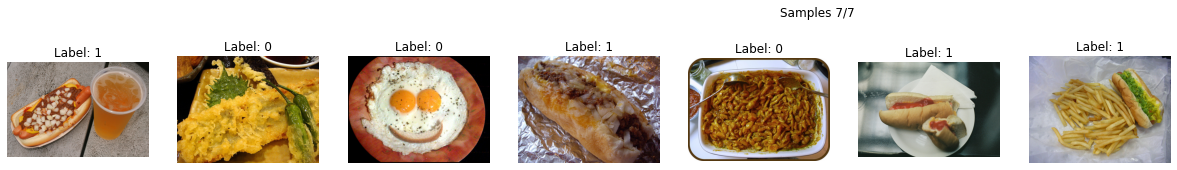

In [4]:
class HotdogOrNotDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.transform = transform
        self.folder = folder
        
        
    def __len__(self):
        return len(os.listdir(self.folder))

    def __getitem__(self, index):
        img_id = os.listdir(self.folder)[index]
        img_path = os.path.join(self.folder, img_id)
        img = Image.open(img_path)
        y = 1 if img_id.startswith('frankfurter') or img_id.startswith('chili-dog') or img_id.startswith('hotdog') else 0

        if self.transform:
            img = self.transform(img)

        return img, y, img_id

def visualize_samples(dataset, indices, title=None, count=10):
    # visualize random 10 samples
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices):    
        x, y, _ = dataset[index]
        plt.subplot(1,count,i+1)
        plt.title("Label: %s" % y)
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')   
    
orig_dataset = HotdogOrNotDataset(train_folder)
indices = np.random.choice(np.arange(len(orig_dataset)), 7, replace=False)

visualize_samples(orig_dataset, indices, "Samples")

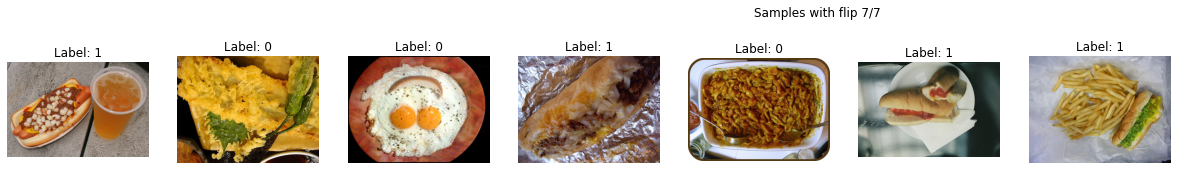

In [5]:
dataset = HotdogOrNotDataset(train_folder, transform=transforms.RandomVerticalFlip(0.9))

visualize_samples(dataset, indices, "Samples with flip")

In [6]:
train_dataset = HotdogOrNotDataset(train_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )
test_dataset = HotdogOrNotDataset(test_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )

In [7]:
batch_size = 10

data_size = len(dataset)
validation_fraction = .2


val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [8]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train()
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y,_) in enumerate(train_loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    model.eval()
    corrects = 0
    num_samples = 0
    for i_step, (x, y, _) in enumerate(loader):
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        probs = torch.softmax(model(x_gpu), dim=1)
        winners = probs.argmax(dim=1)
        corrects += torch.sum(winners == y_gpu)
        num_samples += y_gpu.shape[0]
    return corrects / num_samples


In [9]:
# Transfer learning (freeze all layers)
model = models.resnet18(pretrained=True)
model = model.type(torch.cuda.FloatTensor)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 5)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



Average loss: 0.305460, Train accuracy: 0.872658, Val accuracy: 0.931522
Average loss: 0.256219, Train accuracy: 0.896552, Val accuracy: 0.954348
Average loss: 0.226313, Train accuracy: 0.910128, Val accuracy: 0.953261
Average loss: 0.237599, Train accuracy: 0.907684, Val accuracy: 0.955435
Average loss: 0.220093, Train accuracy: 0.914472, Val accuracy: 0.951087


In [10]:
# Transfer learning (don't freeze any layers)
model = models.resnet18(pretrained=True)
model = model.type(torch.cuda.FloatTensor)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 0.259466, Train accuracy: 0.891664, Val accuracy: 0.944565
Average loss: 0.129248, Train accuracy: 0.952756, Val accuracy: 0.933696
Average loss: 0.079929, Train accuracy: 0.972848, Val accuracy: 0.957609
Average loss: 0.044709, Train accuracy: 0.986424, Val accuracy: 0.957609
Average loss: 0.034620, Train accuracy: 0.988596, Val accuracy: 0.944565


In [11]:
# Transfer learning (different lr for trained and new layers)
model = models.resnet18(pretrained=True)
model = model.type(torch.cuda.FloatTensor)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

loss = nn.CrossEntropyLoss()

optimizer = optim.SGD([
                {'params': model.conv1.parameters()},
                {'params': model.bn1.parameters()},
                {'params': model.relu.parameters()},
                {'params': model.maxpool.parameters()},
                {'params': model.layer1.parameters()},
                {'params': model.layer2.parameters()},
                {'params': model.layer3.parameters()},
                {'params': model.layer4.parameters()},
                {'params': model.avgpool.parameters()},
                {'params': model.fc.parameters(), 'lr': 1e-3}
            ], lr=1e-4, momentum=0.9)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 0.281250, Train accuracy: 0.879446, Val accuracy: 0.947826
Average loss: 0.229624, Train accuracy: 0.907684, Val accuracy: 0.963043
Average loss: 0.188548, Train accuracy: 0.925061, Val accuracy: 0.963043
Average loss: 0.153480, Train accuracy: 0.938908, Val accuracy: 0.960870
Average loss: 0.130896, Train accuracy: 0.948412, Val accuracy: 0.956522
